# Setup

In [12]:
# Import python packages
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import math
from datetime import datetime as dt

# # Cartopy imports
import cartopy.crs as ccrs
from cartopy import util as cutil

from matplotlib import animation
from matplotlib.widgets import Button, Slider
import warnings

import holoviews as hv
import hvplot.xarray
from holoviews import opts
from holoviews import streams
%matplotlib inline
plt.close('all')

From a clean install of python, need to pip install:
notebook, numpy, scipy, xarray, matplotlib, cartopy, holoviews, hvplot

In [2]:
# Loading in dataset:

path = 'H:\\Summer24-25\\' # enter file path here ---> double slashes or change direction eg. \ --> \\ or / 
name = '*_Amon_CESM2-WACCM_ssp126*.nc' # enter file name here --> use * if need multiple files/versions per dataset
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # some datasets have empty values, this ignores that warning--> if gives error, remove this to check
    ds = xr.open_mfdataset(path+name)

# this bit is to change the units of 'plev' (pressure level Pa -> hPa)
if ds.plev.attrs['units'] == 'Pa':
    ds['plev'] = ds.plev / 100
    ds.plev.attrs['axis'] = 'Z' # attributes get reset so have to redo them
    ds.plev.attrs['positive'] = 'down'
    ds.plev.attrs['standard_name'] = 'air_pressure'
    ds.plev.attrs['title'] = 'pressure'
    ds.plev.attrs['type'] = 'double'
    ds.plev.attrs['units'] = 'hPa'

ds.plev

<xarray.DataArray 'plev' (plev: 19)> Size: 152B
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    5.,    1.])
Coordinates:
  * plev     (plev) float64 152B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
Attributes:
    axis:           Z
    positive:       down
    standard_name:  air_pressure
    title:          pressure
    type:           double
    units:          hPa

In [3]:
# default values: **Load this before any following plots **
timeindex = 0
pressurevalue = 200
default_data = ds.isel(time=timeindex).sel(plev=pressurevalue)

ozone = default_data.o3
eastwind = default_data.ua
northwind = default_data.va

fig_dimensions = (14,9)
projection = ccrs.EqualEarth()
transform = ccrs.PlateCarree()
cmap = 'turbo'
cnorm_o3 = mpl.colors.Normalize(vmin=4*10**-8, vmax=5*10**-7)
cnorm_wind = mpl.colors.Normalize(vmin=0, vmax=65)


def timefmt(timeindex, format='%Y %B'):
    date = dt.strptime(str(ds.time[timeindex].values), '%Y-%m-%d %H:%M:%S')
    return date.strftime(format)

# Selecting data:

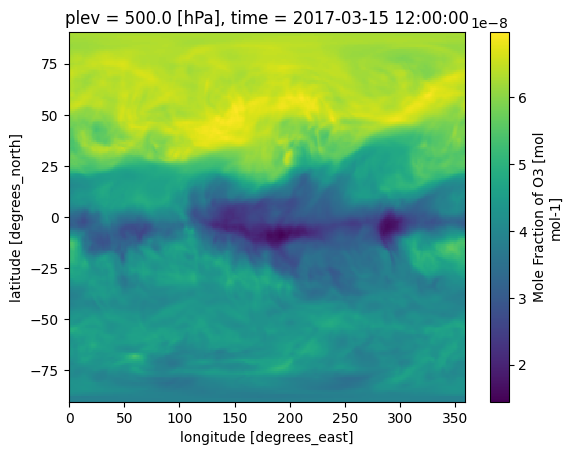

In [11]:
# by value:
ds.o3.sel(time='2017-03-15', plev=500).plot()

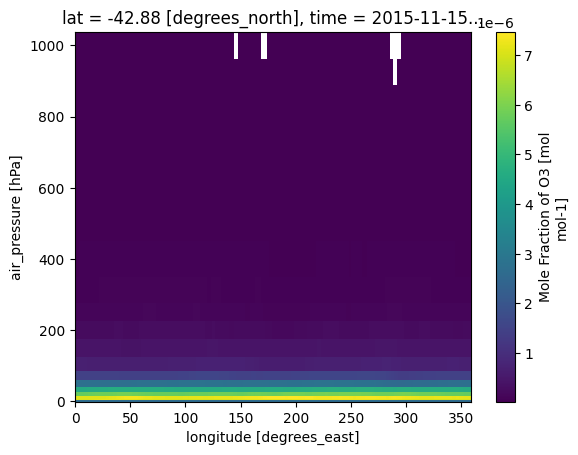

In [62]:
# by index:
ds.o3.isel(time=10, lat=50).plot()

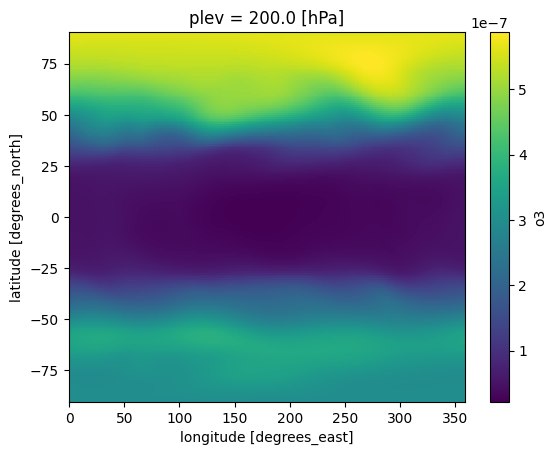

In [5]:
# take average of:
ds.o3.isel(plev=9).mean(dim='time').plot()

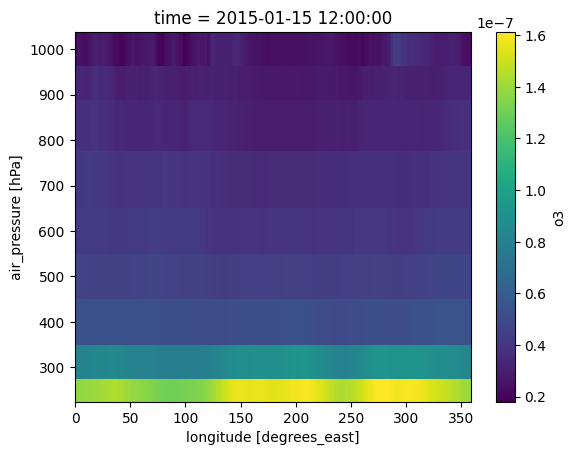

In [6]:
# slicing (selecting a range):
ds.o3.mean(dim='lat').isel(time=0,plev=slice(0,9)).plot()

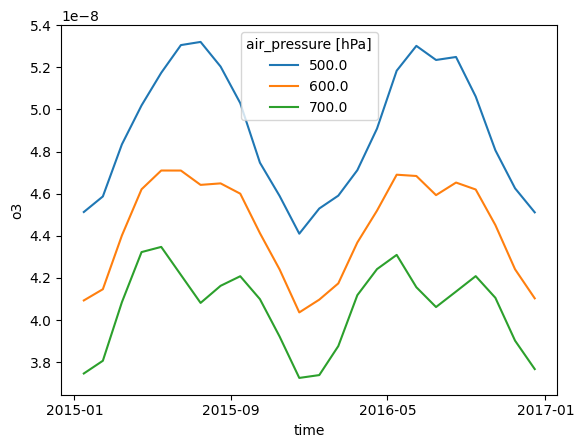

In [7]:
# selecting multiple values
ds.o3.mean(dim='lon').mean(dim='lat').isel(time=slice(0,24), plev=[5,4,3]).plot(hue='plev')

In [8]:
# getting attributes:
ds.o3.time.attrs

{'axis': 'T',
 'bounds': 'time_bnds',
 'standard_name': 'time',
 'title': 'time',
 'type': 'double'}

In [64]:
# converting to string:
print(str(ds.time[6].values))
print(str(ds.plev[3].values)+' hPa')

2015-07-15 12:00:00
700.0 hPa


# Annotation and Customisation

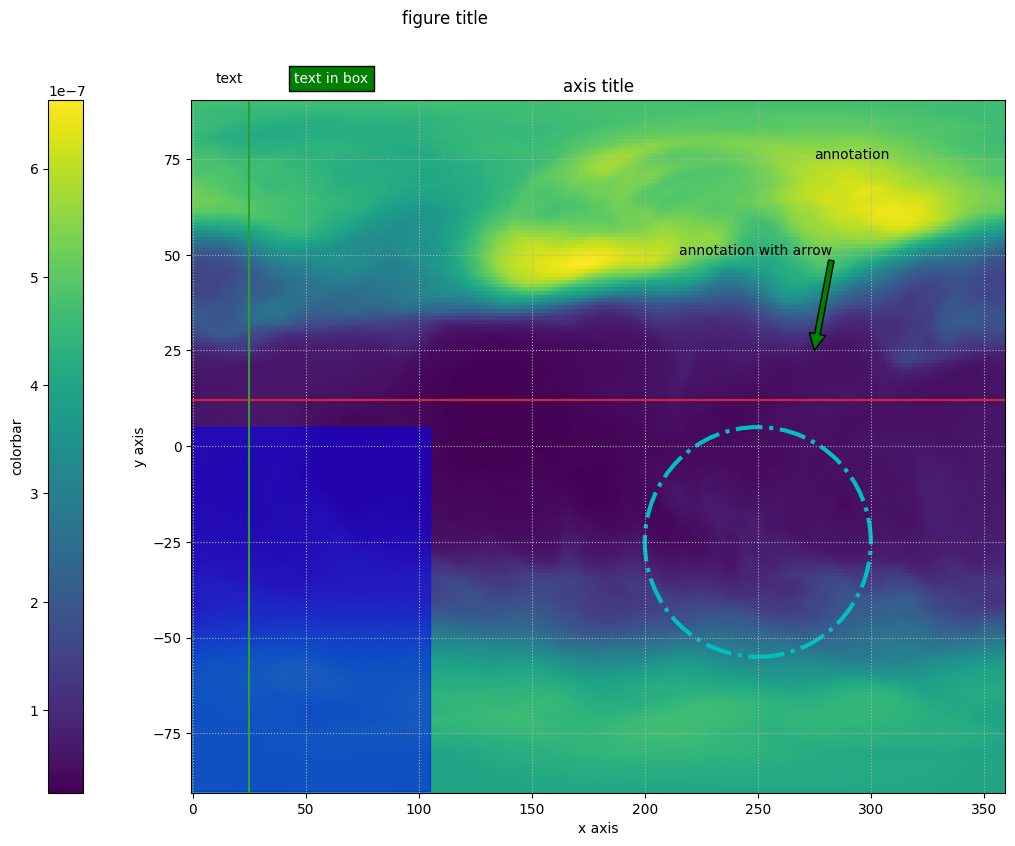

In [13]:
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes()
graph = ozone.plot(ax=ax, add_colorbar=False)


colorbar = fig.colorbar(graph, ax=ax, location='left')

# adding text: (coordinates are based on grid coords)
fig.suptitle('figure title')
ax.set(title='axis title', xlabel='x axis', ylabel='y axis')
plt.text(x=10,y=95, s='text')
plt.text(x=45, y=95, s='text in box', color='w', bbox=dict(fc='g'))
ax.annotate(xy=(275,75), text='annotation')
ax.annotate(xy=(275,25), xytext=(215,50), text='annotation with arrow',arrowprops=dict(fc='g'))
colorbar.set_label("colorbar")
# for all text/titles, can change colour, font, style, size and more

#lines:
ax.axhline(y=12, c='tab:red') #horizontal line
ax.axvline(x=25, c='tab:green') #vertical line
ax.grid(True, ls=':')

#other:
rectangle = plt.Rectangle(xy=(0,-90), width=105, height=95, alpha=0.5, color='b')
circle = mpl.patches.Ellipse(xy=(250, -25), width=100, height=60, ec='c', fc='none', ls='-.', lw=3)
ax.add_patch(rectangle)
ax.add_patch(circle)
rectangle.set_url('https://www.google.com/') # --> can be a web link or file address in same folder/directory

# fig.savefig('annotate.svg') #links in images only work in svg format

# Plots

## Basic

CPU times: total: 4.61 s
Wall time: 4.99 s


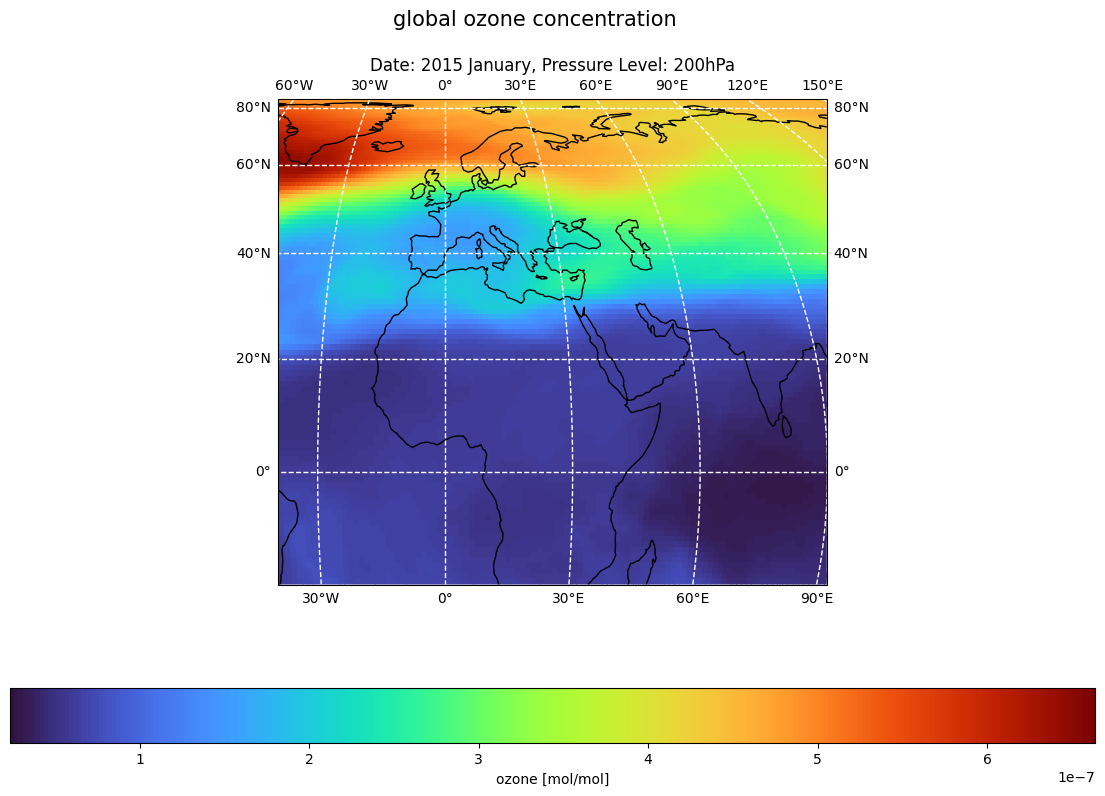

In [14]:
%%time
# location based scalar data

data = ozone

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)

# # with normal colours
graph = data.plot(ax=ax, transform=transform, cmap=cmap, add_colorbar=False)

## details
ax.set_extent([-40,90, -20, 95], crs=transform) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='w', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)
colorbar = fig.colorbar(graph, ax=ax, location='bottom')

## labels/words
colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

Select label locations manually using first mouse button.
End manual selection with second mouse button.


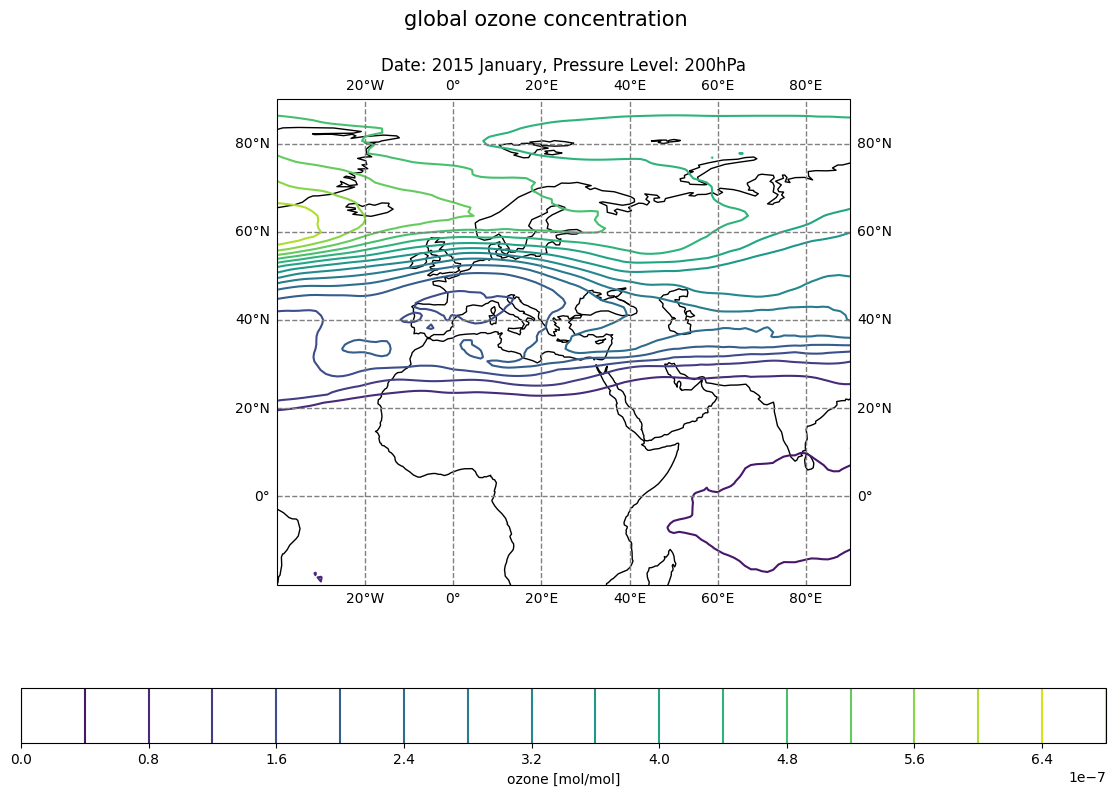

In [112]:
### Only needed for custom contour labels ###
%matplotlib qt
# location based scalar data

data = ozone

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)


# contour lines
data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
graph = ax.contour(lons, ds.lat, data, transform=transform, levels=15)


## details
ax.set_extent([-40,90, -20, 95], crs=transform) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='grey', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)
colorbar = fig.colorbar(graph, ax=ax, location='bottom')

## labels/words
labels = plt.clabel(graph, manual=True) #place custom contour lines (must have %matplotlib qt at top of cell)
colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))

### Only needed for custom contour labels ###
%matplotlib module://matplotlib_inline.backend_inline

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

plt.show()

CPU times: total: 188 ms
Wall time: 194 ms


Text(0.5, 1.0, 'Date: 2015 January, Pressure Level: 200hPa')

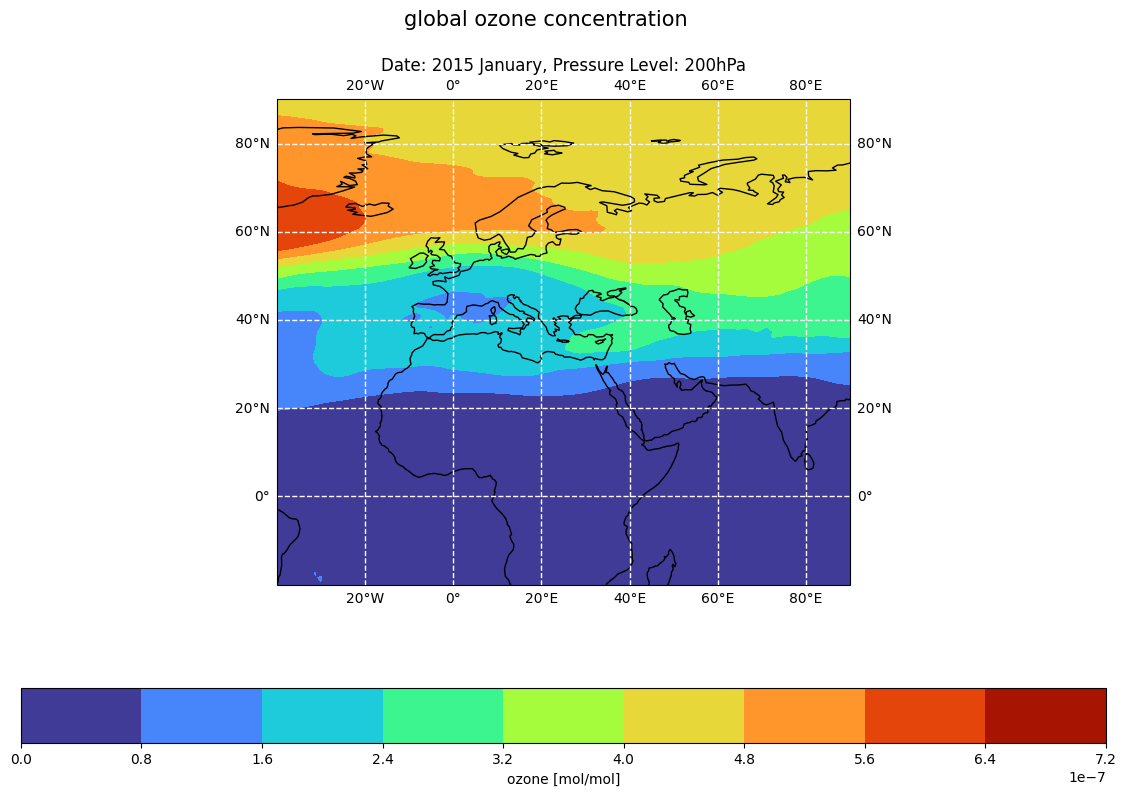

In [114]:
%%time
# location based scalar data

data = ozone

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)

# Filled contour lines
data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
graph = ax.contourf(lons, ds.lat, data, transform=transform, cmap=cmap)

## details
ax.set_extent([-40,90, -20, 95], crs=transform) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='w', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)
colorbar = fig.colorbar(graph, ax=ax, location='bottom')

## labels/words
colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))

# save figure
# fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

CPU times: total: 31.2 ms
Wall time: 35 ms


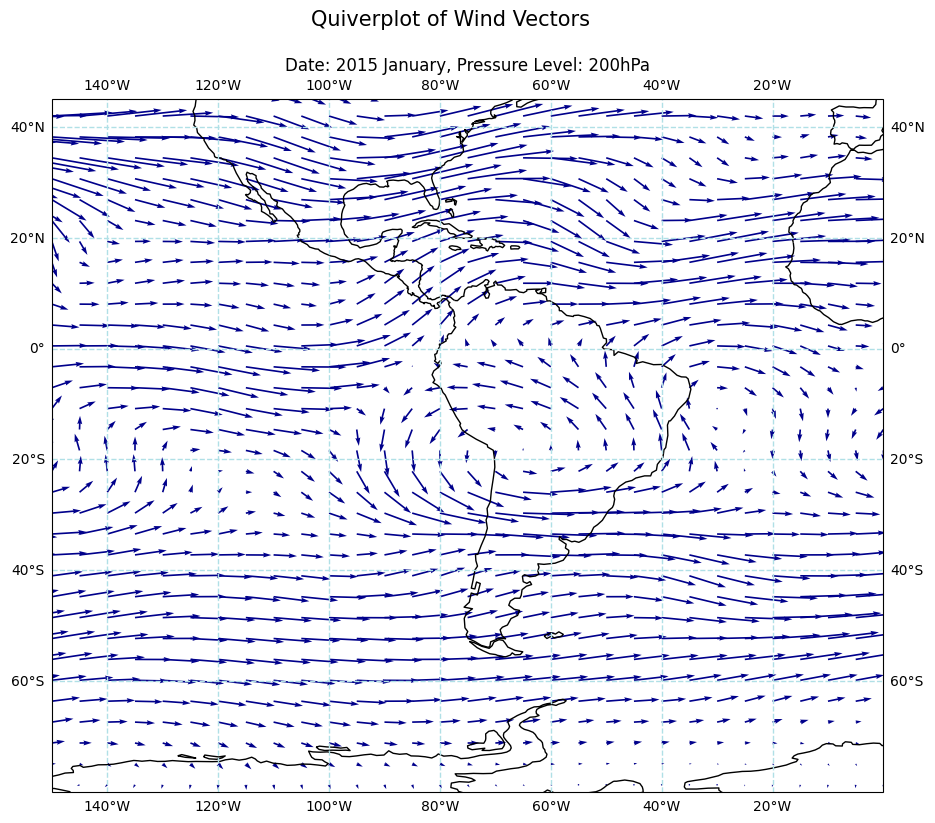

In [115]:
%%time
# location based vector data--> option 1: Quivers

# select and prepare data
u = eastwind[::4, ::4]
v = northwind[::4, ::4]
windspeed = (u**2 + v**2)**0.5
projection = ccrs.PlateCarree(central_longitude=0) # only works with rectangular/square projections

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)

## details
ax.set_extent([-150,0, -80, 45], crs=transform) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='powderblue', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)

## labels/words
colorbar.set_label(label='windspeed (m/s)', size=10)
fig.suptitle(t='Quiverplot of Wind Vectors', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))



# # plain coloured arrows
qv = ax.quiver(u.lon, u.lat, u, v, color='darkblue', scale=600, width=0.002, transform=ccrs.PlateCarree())

# # arrows coloured by strength
# qv = ax.quiver(u.lon, u.lat, u, v, windspeed, cmap=cmap, scale=600, width=0.002, transform=ccrs.PlateCarree())

# # but could also color this by a secondary variable...
# secondvar = ozone[::4, ::4]
# qv = ax.quiver(u.lon, u.lat, u, v, secondvar, cmap=cmap, scale=600, width=0.002, transform=ccrs.PlateCarree())
# colorbar = fig.colorbar(qv, ax=ax, location='bottom')



# save figure
# fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\vector_quiverplot.png')

CPU times: total: 1.62 s
Wall time: 679 ms


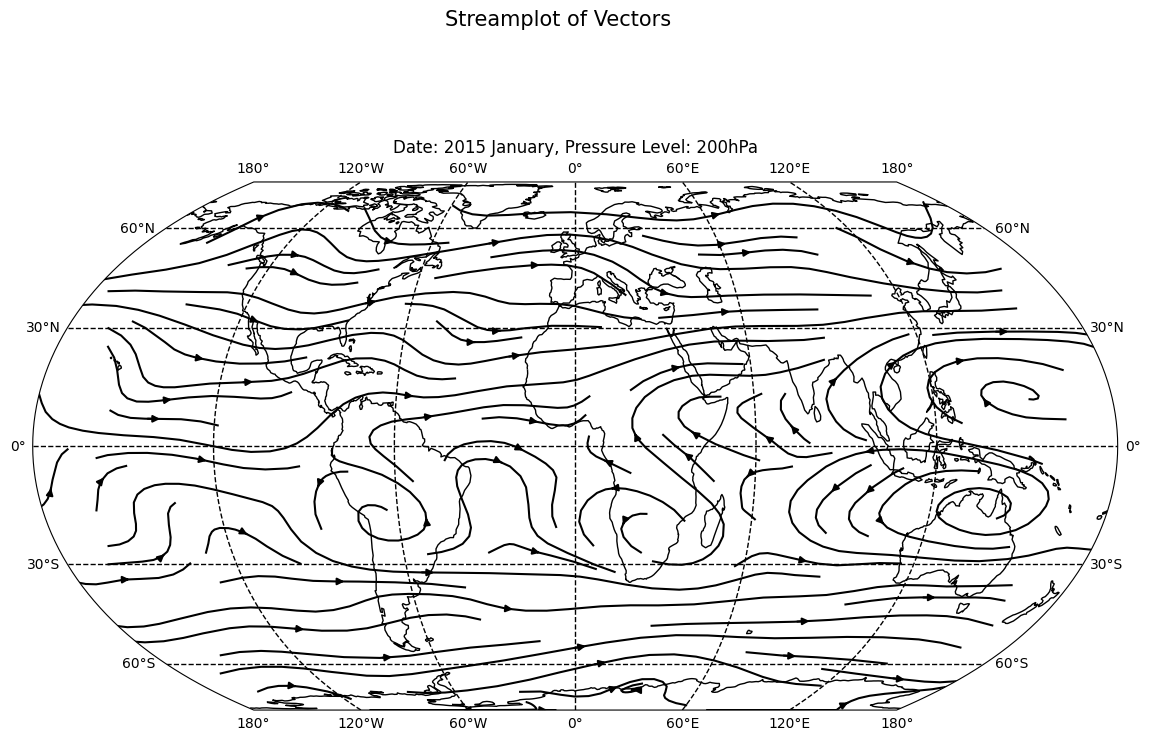

In [116]:
%%time
# location based vector data--> option 2: Streamplot

# select and prepare data
u = eastwind[::4, ::4]
v = northwind[::4, ::4]
windspeed = (u**2 + v**2)**0.5
linewidth = 4* (windspeed.values / windspeed.values.max())
projection = ccrs.EqualEarth()

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)

## details
ax.gridlines(color='k', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)

## labels/words
colorbar.set_label(label='windspeed (m/s)', size=10)
fig.suptitle(t='Streamplot of Vectors', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))



# options for streamplot: 

# Plain: streamplot color='k', comment out windspeed.plot and fig.colorbar lines
strm = ax.streamplot(u.lon, u.lat, u, v, transform=transform, color='k')

# # Windspeed= Background Colour --> windspeed.plot(...) with streamplot color='w'
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=transform, color='w')
# bg = windspeed.plot(ax=ax, cmap=cmap, transform=transform, add_colorbar=False)
# colorbar = fig.colorbar(bg, ax=ax, location='bottom')

# # Windspeed= Streamline Colour --> add color=windspeed.values, cmap=cmap to streamplot call, change colorbar call to strm.lines not bg
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=transform, color=windspeed.values, cmap=cmap)
# colorbar = fig.colorbar(strm.lines, ax=ax, location='bottom')

# # Windspeed= Line Width --> add lw=linewidth to streamplot call
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=transform, color='k', linewidth=linewidth)

# # Continuous Lines --> add broken_streamlines=False to streamplot call, and lower density
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=transform, color='k', broken_streamlines=False, density=0.75)



# save figure
# fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\vector_streamplot.png')

CPU times: total: 2.69 s
Wall time: 3.4 s


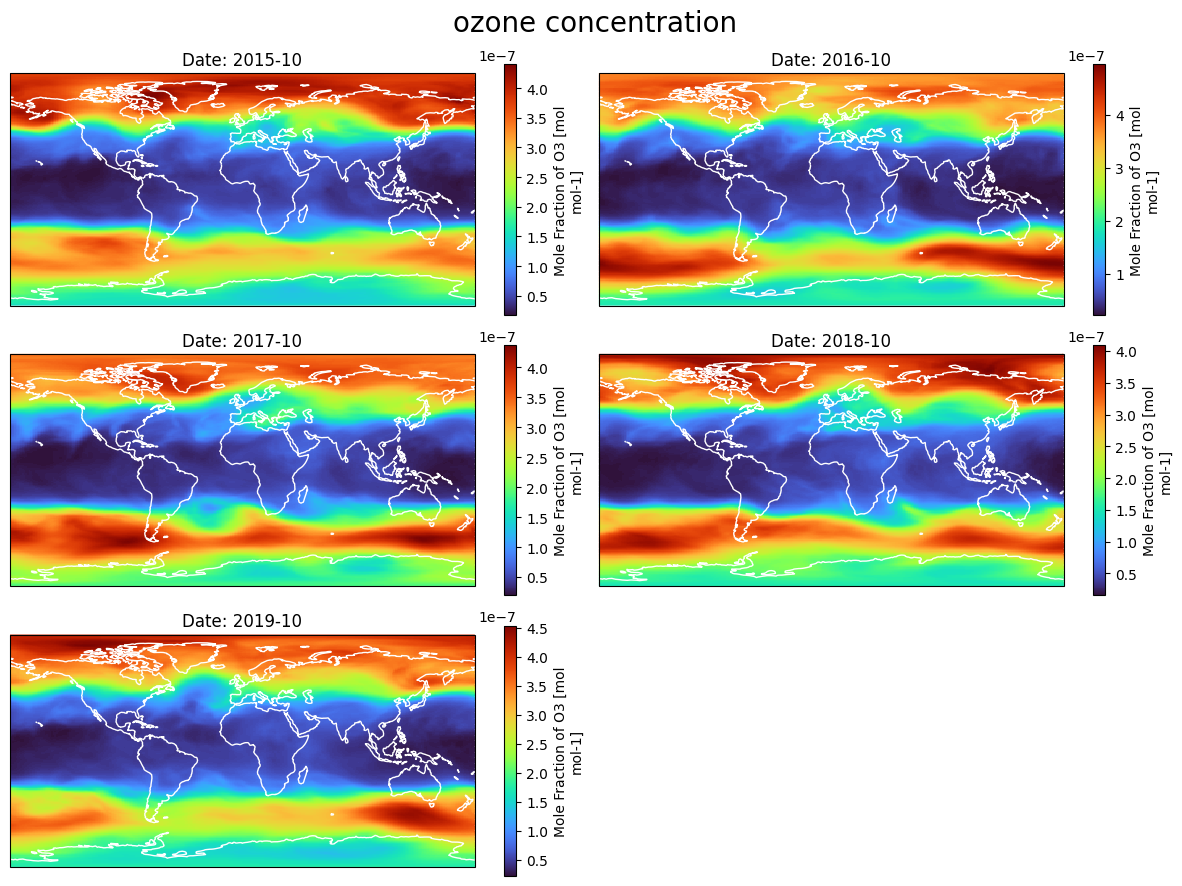

In [69]:
%%time
# Subplots - multiple plots, one figure --> autofit grid to number of times
times = ['2015-10', '2016-10', '2017-10', '2018-10', '2019-10'] # values- use with ds.o3.sel
# times = [9, 21, 33, 45] # indices- use with ds.o3.isel

ds_constants = ds.o3.sel(plev=200) # setting pressure level to 200hPa

row,col = math.ceil(len(times)**0.5), round(len(times)**0.5)
fig, axs = plt.subplots(row,col, figsize=(col*6, row*3), layout='tight', subplot_kw=
                        {'projection': projection})

fig.suptitle('ozone concentration', size=20)
i = 0
for ax in axs.flat:
    if i < len(times):
        # by values: 
        ds_constants.sel(time=times[i]).plot(ax=ax, transform=transform, cmap=cmap)
        ax.set_title('Date: %s' %times[i])

        # # by indices:
        # ds_constants.isel(time=times[i]).plot(ax=ax, transform=transform, cmap=cmap)
        # ax.set_title('Date: %s' %timefmt(times[i]))

        
        ax.coastlines(color='w')
        i += 1
    else:
        ax.remove()

fig.savefig('vary_subplots_example.png')

## Animated

CPU times: total: 11.5 s
Wall time: 13.4 s


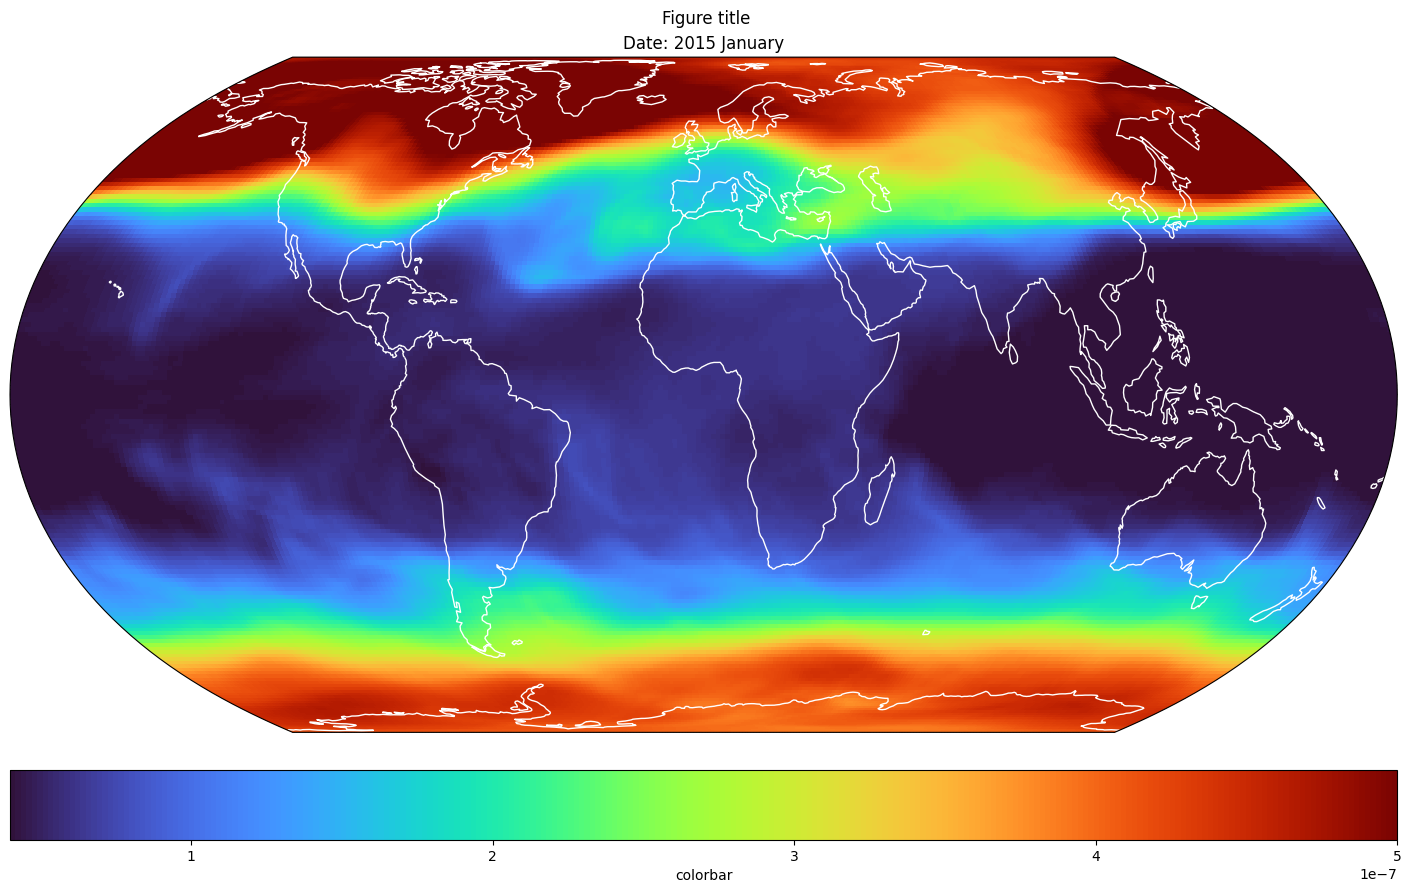

In [6]:
%%time
# animated plots --> animated by timestep -> dataset must have time coordinates

ds_constants = ds.o3.sel(plev=200) # fixing pressure level at 200hPa
num_frames = 25


fig = plt.figure(figsize=fig_dimensions, layout='compressed')
ax=plt.axes(projection=projection)

fig.suptitle('Figure title')

graph = ds_constants.isel(time=0).plot.pcolormesh(ax=ax, cmap=cmap, norm=cnorm_o3, transform=transform, add_colorbar=False)
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm_o3, cmap=cmap), ax=ax, location='bottom', label='colorbar')
ax.coastlines(color='w')

def animate(num): # function to update each frame
    graph.set_array(ds_constants.isel(time=num))
    ax.set_title('Date: %s' %timefmt(num))

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200)

anim.save('normnorm.gif', writer='pillow')


## Interactive plots

The default matplotlib backend doesn't work interactively, so we must change it. The options for this are generally: qt / qtagg or tk / tkagg. 
Implement this using %matplotlib qt or %matplotlib tk at the top of whichever cell you are using. This will set it from then on, so when you want to go back to the normal inline plots, use %matplotlib inline

Select label locations manually using first mouse button.
End manual selection with second mouse button.


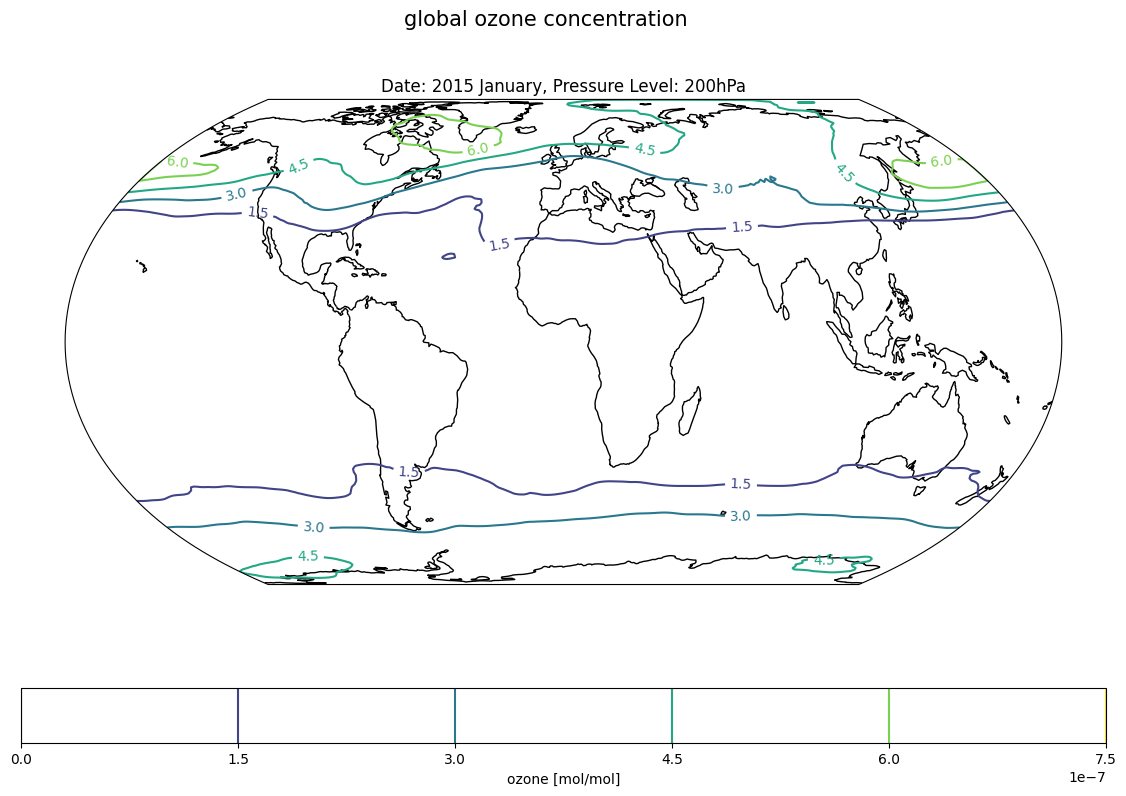

In [14]:
### Only needed for custom contour labels ###
%matplotlib qt
# location based scalar data

data = ozone

## Plotting
fig = plt.figure(figsize=fig_dimensions)
ax = plt.axes(projection=projection)
data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
graph = ax.contour(lons, ds.lat, data, transform=transform, levels=5)
colorbar = fig.colorbar(graph, ax=ax, location='bottom')
ax.coastlines(color='k', linewidth=1)

## labels/words
fig.suptitle(t='click for label, middle button to exit', size=15) ### Only needed for custom contour labels ###
labels = plt.clabel(graph, manual=True) #place custom contour lines (must have %matplotlib qt at top of cell)

colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(timeindex), pressurevalue))

### Only needed for custom contour labels ###
%matplotlib inline

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

plt.show()

In [18]:
%matplotlib qt
## Interactive with matplotlib interface, more work but better control
## adapted from https://matplotlib.org/stable/gallery/widgets/slider_demo.html and https://matplotlib.org/stable/gallery/widgets/slider_snap_demo.html
init_plev = pressurevalue
init_time = timeindex
fig = plt.figure(figsize=fig_dimensions)
ax = fig.add_subplot(projection=projection)
ax.coastlines()
ax.set_global()

graph = ds.o3.isel(time=init_time).sel(plev=init_plev).plot.pcolormesh(ax=ax, transform=transform, cmap=cmap)
ax.set_title('Date: %s' %timefmt(init_time))
fig.subplots_adjust(left=0.2, bottom=0.25)

# horizontal slider --> time
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax=axtime, label='Time (Month)', valmin=0, valmax=24, valstep=1, valinit=init_time,)

# vertical slider -> plev
axplev = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
plev_slider = Slider(ax=axplev, label='Pressure Level (hPa)', valmin=70, valmax=400, 
                     valstep=ds.plev, valinit=init_plev, orientation="vertical",)

def update(val):
    graph.set_array(ds.o3.isel(time=time_slider.val).sel(plev=plev_slider.val))
    ax.set_title('Date: %s' %timefmt(time_slider.val))
    fig.canvas.draw_idle()
    print('UPDASTE')

def reset(event):
    time_slider.reset()
    plev_slider.reset()
    print('RESEET')

def close(event):
    # %matplotlib inline
    axtime.remove()
    axplev.remove()
    resetax.remove()
    # closeax.remove()
    # fig.layout = 'tight'
    # fig.savefig('H:\\Summer24-25\\Jupyter\\TEST.png')
    print('AHHHHHH')
    # plt.show()

# register the update function with each slider
time_slider.on_changed(update)
plev_slider.on_changed(update)

# make button to reset sliders to init_values
resetax = fig.add_axes([0.69, 0.025, 0.1, 0.04])
reset_button = Button(resetax, 'Reset', hovercolor='0.975')
reset_button.on_clicked(reset)

# make button to reset sliders to init_values
closeax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
close_button = Button(closeax, 'Close', hovercolor='r')
close_button.on_clicked(close)

0

UPDASTE
UPDASTE
UPDASTE
AHHHHHH


Traceback (most recent call last):
  File "C:\Python312\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
  File "C:\Python312\Lib\site-packages\matplotlib\widgets.py", line 233, in _motion
    self.ax.draw_artist(self.ax)
  File "C:\Python312\Lib\site-packages\matplotlib\axes\_base.py", line 3147, in draw_artist
    a.draw(self.figure.canvas.get_renderer())
           ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'canvas'
Traceback (most recent call last):
  File "C:\Python312\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
  File "C:\Python312\Lib\site-packages\matplotlib\widgets.py", line 233, in _motion
    self.ax.draw_artist(self.ax)
  File "C:\Python312\Lib\site-packages\matplotlib\axes\_base.py", line 3147, in draw_artist
    a.draw(self.figure.canvas.get_renderer())
           ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'canvas'
Traceback (most recent c

In [10]:
%matplotlib qt
## Interactive with matplotlib interface, more work but better control
## adapted from https://matplotlib.org/stable/gallery/widgets/slider_demo.html and https://matplotlib.org/stable/gallery/widgets/slider_snap_demo.html
init_plev = pressurevalue
init_time = timeindex
fig = plt.figure(figsize=fig_dimensions)
ax = fig.add_subplot(projection=projection)
ax.coastlines()
ax.set_global()

graph = ds.o3.isel(time=init_time).sel(plev=init_plev).plot.pcolormesh(ax=ax, transform=transform, cmap=cmap)
ax.set_title('Date: %s' %timefmt(init_time))
fig.subplots_adjust(left=0.25, bottom=0.25)

# horizontal slider --> time
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax=axtime, label='Time (Month)', valmin=0, valmax=24, valstep=1, valinit=init_time,)

# vertical slider -> plev
axplev = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
plev_slider = Slider(ax=axplev, label='Pressure Level (hPa)', valmin=70, valmax=400, 
                     valstep=ds.plev, valinit=init_plev, orientation="vertical",)

def update(val):
    graph.set_array(ds.o3.isel(time=time_slider.val).sel(plev=plev_slider.val))
    ax.set_title('Date: %s' %timefmt(time_slider.val))
    fig.canvas.draw_idle()

def reset(event):
    time_slider.reset()
    plev_slider.reset()

# register the update function with each slider
time_slider.on_changed(update)
plev_slider.on_changed(update)

# make button to reset sliders to init_values
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
    
button.on_clicked(reset)

0

In [ ]:
%matplotlib inline
### use to reset to normal plots ----> use AFTER CLOSING plot generated above

In [12]:
data = ds.o3.isel(time=slice(0,24), plev=slice(6,11))
## Interactive with holoview interface, less work but slower and less control
hv.output(widget_location='bottom')

graph = data.hvplot(
    'lon', 'lat', projection=ccrs.Orthographic(90), global_extent=True, project=True, 
    cmap='turbo', coastline=True, size=500, clim=(10**-8, 5*10**-7)
)

hvplot.save(graph, 'graph.html') ##use html to be able to interact, then use the save tool within file to save specific time/plev

In [7]:
data = ds.o3.isel(time=slice(0,12), plev=slice(6,11))
graph = data.hvplot('lon','lat', projection=projection, project=True, coastline=True, size=600, cnorm='log')
path = hv.Path([])
freehand = streams.FreehandDraw(source=path, num_objects=5)
path.opts(active_tools=['freehand_draw'], height=500, line_width=5, width=1000, color='r')
# hvplot.save(graph*path, 'test-draw.html')
hvplot.show(graph*path)

Launching server at http://localhost:49888
